# Apple Tweets Modeling

In [211]:
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
import datetime as dt
import random
from collections import Counter
from scipy import sparse

import pickle
import os
import re
import string
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk
from nltk.tokenize import MWETokenizer
import gensim
import emoji
from spellchecker import SpellChecker
from textblob import TextBlob
from langdetect import detect

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

import scattertext as st
from biterm.utility import vec_to_biterms
from biterm.btm import oBTM
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

from helper_functions import display_topics

### Load tweet data

In [60]:
# read pickle for df
df = pd.read_pickle('tweet_clean.pkl')

# read pickle for df convo user
df_convo_user = pd.read_pickle('df_convo_user.pkl')

### Vectorize data

In [18]:
# vectorize text data using tf-idf vectorizer
my_additional_stop_words = ['apple', 'applesupport', 'want', 'hey', 'hi', 'hello', 'http', 'thank', 'thanks', 'ok', 'yes', 'pls', 'plz', 'know', 'going', 'like', 'really', 'la', 'le', 'que', 'question', 'mark']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

tfidf_convo_user = TfidfVectorizer(stop_words=my_stop_words, max_df=0.10, min_df=0.001, ngram_range=(1,3))
doc_word_convo_user = tfidf_convo_user.fit_transform(df_convo_user.text_clean)

df_convo_user_vec = pd.DataFrame(doc_word_convo_user.toarray(), index=df_convo_user.text_clean, columns=tfidf_convo_user.get_feature_names())

In [4]:
df_convo_user_vec.shape

(58578, 1839)

In [5]:
df_convo_user_vec.sample(1)

,ability,able,able use,absolute,absolutely,accept,access,accidentally,account,act,...,yeah,year,year ago,year old,yep,yesterday,yo,youtube,yup,zero
text_clean,,,,,,,,,,,,,,,,,,,,,
applesupport update coming stop looking like question mark really,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Explore Topics

### Topic Modeling

In [19]:
# use NMF model to reduce dimensionality to some # of topics
nmf_model_convo_user = NMF(25)
doc_topic_convo_user = nmf_model_convo_user.fit_transform(doc_word_convo_user)

In [20]:
# topics by words
nmf_model_convo_user.components_.shape

(25, 1839)

In [21]:
# distribution of words by topic
np.unique(doc_topic_convo_user.argmax(axis=1), return_counts = True)[1]

array([4101, 4276, 1097, 2066, 2130, 3082, 2112, 1751, 1048, 2092, 1441,
       1585, 2369, 1425, 2273, 1085, 2995, 1562, 1535, 2837, 1186, 5830,
       3526, 3704, 1470])

In [22]:
# topics by words into dataframe
topic_word_convo_user = pd.DataFrame(nmf_model_convo_user.components_.round(3),
                         #index = ["component_1", "component_2", "component_3", "component_4"]
                         columns = tfidf_convo_user.get_feature_names())

topic_word_convo_user.head()

,ability,able,able use,absolute,absolutely,accept,access,accidentally,account,act,...,yeah,year,year ago,year old,yep,yesterday,yo,youtube,yup,zero
0,0.028,0.197,0.016,0.008,0.016,0.024,0.199,0.024,2.013,0.012,...,0.057,0.115,0.044,0.000,0.018,0.151,0.012,0.000,0.001,0.016
1,0.000,0.000,0.000,0.010,0.042,0.000,0.000,0.000,0.000,0.002,...,0.001,0.061,0.003,0.027,0.000,0.019,0.007,0.017,0.004,0.011
2,0.004,0.000,0.019,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.001,0.001,0.000,0.000,0.001,0.000,0.082,0.000,0.000,0.000
3,0.000,0.032,0.001,0.000,0.001,0.005,0.000,0.000,0.000,0.003,...,0.016,0.010,0.000,0.004,0.000,0.014,0.010,0.007,0.001,0.004
4,0.002,0.016,0.000,0.000,0.008,0.005,0.000,0.000,0.000,0.000,...,0.011,0.007,0.001,0.000,0.008,0.029,0.002,0.007,0.007,0.007


In [212]:
display_topics(nmf_model_convo_user, tfidf_convo_user.get_feature_names(), 5)


Topic  0
email, got, account, id, received

Topic  1
battery, life, battery life, drain, battery drain

Topic  2
letter, type letter, eye, letter eye, use

Topic  3
issue, fix issue, fixed, issue iphone, issue io

Topic  4
problem, fix problem, fixed, problem iphone, solve

Topic  5
new, new update, new io, new iphone, new phone

Topic  6
work, tried, phone work, work phone, fine

Topic  7
updated, updated phone, updated io, updated iphone, seeing

Topic  8
need, need help, need fix, fixed, answer

Topic  9
app, store, app store, download, open

Topic  10
shit, fix shit, fucking, fuck, yo

Topic  11
plus, iphone plus, plus io, iphone plus io, io iphone plus

Topic  12
music, song, itunes, play, playing

Topic  13
dm, sent, sent dm, check, check dm

Topic  14
screen, lock, lock screen, black, home

Topic  15
happening, thing, explain, started, started happening

Topic  16
time, day, time day, time type, phone time

Topic  17
working, stopped, stopped working, stop, stop working

Topic 

In [65]:
doc_topic_nmf_convo_user = pd.DataFrame(doc_topic_convo_user.round(5),
                             index = df_convo_user.text_clean)
doc_topic_nmf_convo_user.head(3)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
text_clean,,,,,,,,,,,,,,,,,,,,,
applesupport uh weirdness watchos update http co,0.00000,0.00008,0.0,0.00009,0.00034,0.00005,0.00000,0.00069,0.00007,0.00066,...,0.00032,0.00049,0.00003,0.00015,0.00000,0.00037,0.00031,0.00149,0.00000,0.00000
sure f happening io trying let battery run lie battery life hour applesupport sup widdat http co,0.00268,0.13645,0.0,0.00000,0.00000,0.00000,0.00073,0.00000,0.00000,0.00190,...,0.07903,0.00000,0.00048,0.00000,0.00000,0.00000,0.00304,0.00291,0.00000,0.00279
applesupport good thanks able send least half dozen animoji,0.00298,0.00352,0.0,0.00027,0.00051,0.00313,0.00383,0.00001,0.00047,0.00087,...,0.00000,0.00258,0.00089,0.00018,0.00127,0.00012,0.00352,0.02258,0.00111,0.00243


In [66]:
# get the diff between max and min date
df_convo_user['max_min_date_diff'] = df_convo_user.date_only_max - df_convo_user.date_only_min
df_convo_user = df_convo_user[['author_id', 'text', 'text_clean', 'date_only_min', 'date_only_max', 'max_min_date_diff']]

In [67]:
# get topic with max value for each document
doc_topic_nmf_convo_user['topic'] = doc_topic_nmf_convo_user.idxmax(axis=1)
doc_topic_nmf_convo_user = doc_topic_nmf_convo_user.reset_index()

In [68]:
# merge df convo user with topic
df_convo_user = pd.merge(df_convo_user, doc_topic_nmf_convo_user['topic'], left_index=True, right_index=True)

In [69]:
df_convo_user.head(5)

,author_id,text,text_clean,date_only_min,date_only_max,max_min_date_diff,topic
0,408,"@AppleSupport Uh, weirdness after watchOS 4.1 ...",applesupport uh weirdness watchos update http co,2017-11-02,2017-11-02,0 days,22
1,1437,I'm not sure what the F is happening with iOS ...,sure f happening io trying let battery run lie...,2017-11-17,2017-11-17,0 days,1
2,1501,@AppleSupport all good now thanks. i’ve been a...,applesupport good thanks able send least half ...,2017-11-03,2017-11-03,0 days,22
3,2084,@AppleSupport Just updated iTunes and it said ...,applesupport updated itunes said longer subscr...,2017-10-31,2017-10-31,0 days,12
4,3922,@AppleSupport Pretty sure it started with iOS ...,applesupport pretty sure started io seems happ...,2017-10-07,2017-10-08,1 days,22


### EDA

In [10]:
df_convo_user.date_only_min.sort_values()

6865    2016-03-04
56758   2016-04-04
52236   2016-09-06
23096   2016-10-01
57696   2016-10-06
           ...    
11336   2017-12-03
11337   2017-12-03
11338   2017-12-03
11340   2017-12-03
11089   2017-12-03
Name: date_only_min, Length: 58578, dtype: datetime64[ns]

In [11]:
df_convo_user[df_convo_user.date_only_min < '2016-04-05']

,author_id,text,text_clean,date_only_min,date_only_max
6865,202183,@AppleSupport Howdy. I will be upgrading my 7 ...,applesupport howdy upgrading x early morning a...,2016-03-04,2017-10-08
56758,790357,@AppleSupport i was just wondering how you get...,applesupport wondering get rid padlock icon to...,2016-04-04,2016-04-04


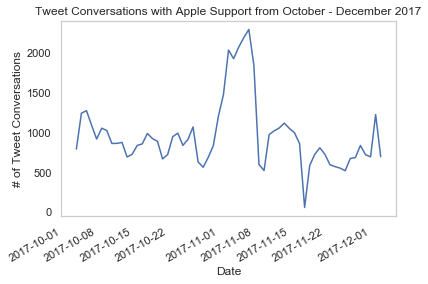

In [187]:
# plot tweet conversation volume from 10/04/17 to 12/03/17
df_convo_graph = df_convo_user.groupby(['date_only_min']).size().reset_index(name='counts')

sns.lineplot(data=df_convo_graph[df_convo_graph.date_only_min > '2017-10-03'], x='date_only_min', y='counts', color='b') 

plt.title('Tweet Conversations with Apple Support from October - December 2017')
plt.xlabel('Date')
plt.ylabel('# of Tweet Conversations')
plt.gcf().autofmt_xdate()
plt.savefig('conversation_volume.png');

In [30]:
# create dataframe for time series graph of topics
df_topic_graph = df_convo_user.groupby(['date_only_min', 'topic']).size().reset_index(name='counts')
df_topic_graph.head()

,date_only_min,topic,counts
0,2016-03-04,22,1
1,2016-04-04,4,1
2,2016-09-06,21,1
3,2016-10-01,23,1
4,2016-10-06,21,1


In [31]:
# total documents 
sum(df_topic_graph.counts)

58578

In [32]:
# total documents from Oct 4 - Dec 3 2017
sum(df_topic_graph[df_topic_graph.date_only_min > '2017-10-03'].counts)

58294

In [33]:
# percent of documents in entire dataset
58294 / 58578

0.9951517634606849

**58,294 of 58,578 tweets in date range (99.5%) from October 4, 2017 to December 3, 2017 (2 months)**

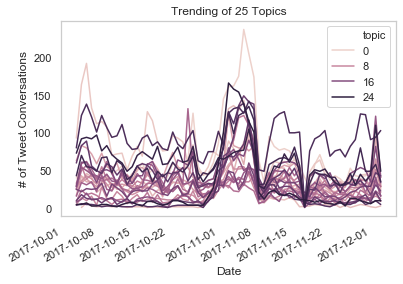

In [188]:
sns.lineplot(data=df_topic_graph[df_topic_graph.date_only_min > '2017-10-03'], x='date_only_min', y='counts', hue='topic') #, palette=sns.color_palette()) 

plt.title('Trending of 25 Topics')
plt.xlabel('Date')
plt.ylabel('# of Tweet Conversations')
plt.gcf().autofmt_xdate();

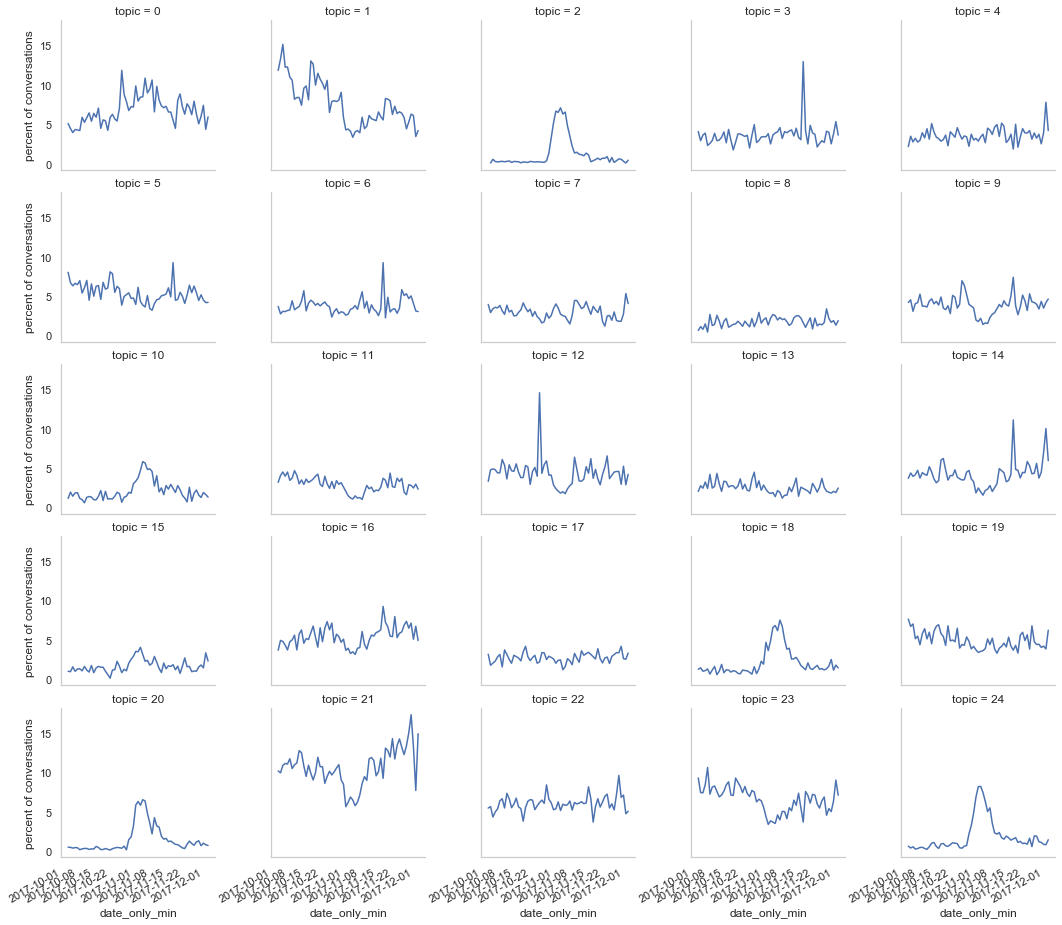

In [189]:
# create percent of all conversation per topic
df_topic_graph_pct = df_topic_graph.merge(df_convo_graph[['date_only_min', 'counts']], how='left', on='date_only_min')

df_topic_graph_pct['percent of conversations'] = (df_topic_graph_pct.counts_x / df_topic_graph_pct.counts_y) * 100

# plot percent of conversations by topic
g = sns.FacetGrid(df_topic_graph_pct[df_topic_graph_pct.date_only_min > '2017-10-03'], col="topic", col_wrap=5, height=3.0, aspect=1.0) 
g = g.map(plt.plot, "date_only_min", "percent of conversations", color='b') 
plt.gcf().autofmt_xdate()
plt.savefig('percent_daily_tweets_by_topic.png');

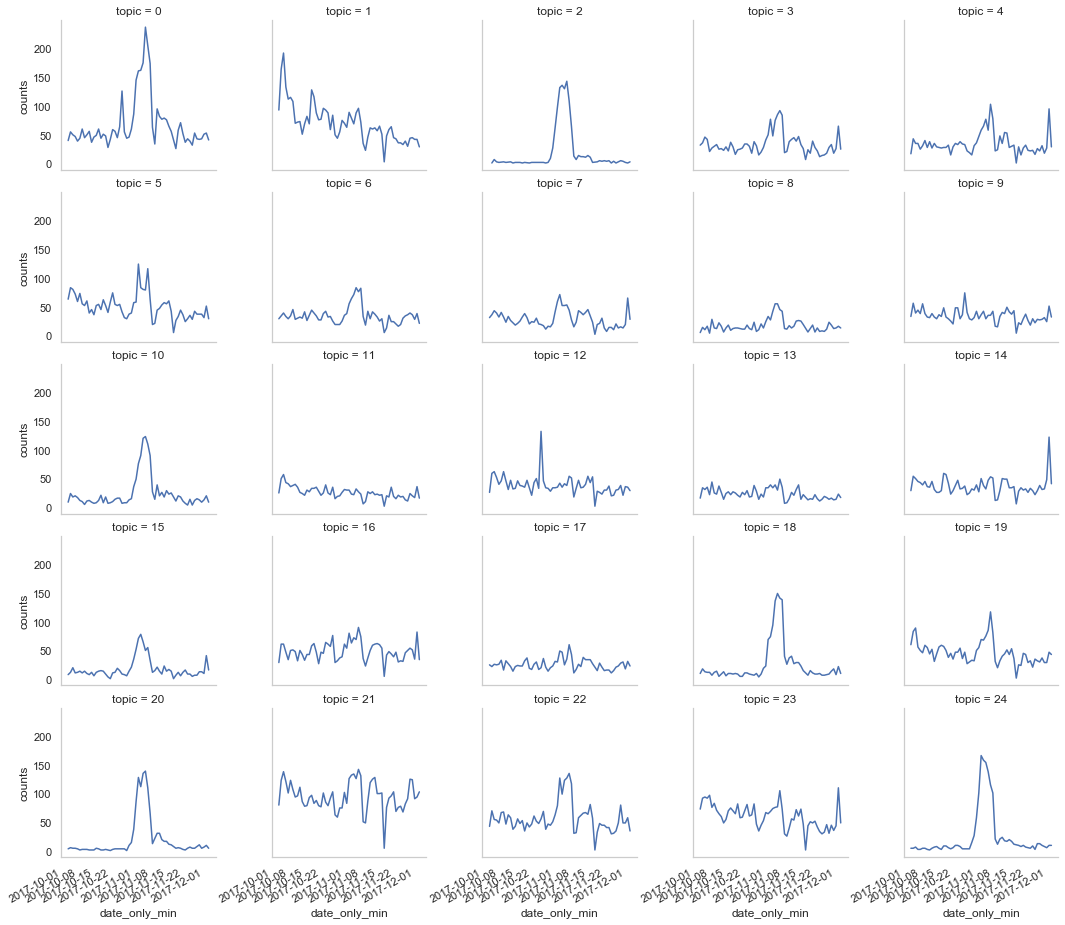

In [191]:
# plot counts of conversations by topic
g = sns.FacetGrid(df_topic_graph[df_topic_graph.date_only_min > '2017-10-03'], col="topic", col_wrap=5, height=3.0, aspect=1.0) 
g = g.map(plt.plot, "date_only_min", "counts", color='b') #sns.lineplot
plt.gcf().autofmt_xdate()
plt.savefig('daily_tweets_by_topic.png');

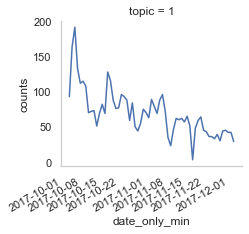

In [192]:
# plot counts of conversations for topic 1
g = sns.FacetGrid(df_topic_graph[(df_topic_graph.date_only_min > '2017-10-03') & (df_topic_graph.topic == 1)], col="topic", col_wrap=5, height=3.0, aspect=1.0) 
g = g.map(plt.plot, "date_only_min", "counts", color='b') #sns.lineplot
plt.gcf().autofmt_xdate();

**Next step is to investigate and further explore some of these topics and compare against Apple's timeline:**  

Battery life:  
- Topic  1:  battery, life, battery life, drain, battery drain  

Screen bug:   
- Topic  14:  screen, lock, lock screen, black, home  

Email bug:  
- Topic  16:  email, got, account, id, received  

Auto-Correct bug:
- Topic  0:  time, day, time day, time type, phone time
- Topic  2:  letter, type letter, eye, letter eye, use
- Topic  10:  shit, fix shit, fucking, fuck, yo
- Topic  18:  glitch, fix glitch, fixed, annoying, keyboard
- Topic  19:  box, seeing, seeing box, fix box, thing
- Topic  21:  message, text, photo, getting, send  
- Topic  24:  type, type letter, time type, come, weird  

Others:  
- Topic  3: issue, fix issue, fixed, issue iphone, issue io  
- Topic  4: problem, fix problem, fixed, problem iphone, solve  
- Topic  5: new, new update, new io, new iphone, new phone  
- Topic  6: work, tried, phone work, work phone, fine  
- Topic  7: updated, updated phone, updated io, updated iphone, seeing  
- Topic  8: need, need help, need fix, fixed, answer  
- Topic  9: app, store, app store, download, open  
- Topic  11: plus, iphone plus, plus io, iphone plus io, io iphone plus  
- Topic  12: music, song, itunes, play, playing  
- Topic  13: dm, sent, sent dm, check, check dm  
- Topic  15: happening, thing, explain, started, started happening  
- Topic  17: turn, wifi, bluetooth, turning, control  
- Topic  20: working, stopped, stopped working, stop, stop working
- Topic  22: sierra, macbook, high, high sierra, pro
- Topic  23: apps, amp, freezing, slow, crashing

### Plot t-SNE

In [52]:
# create tsne model
tsne_model = TSNE(n_components=2, verbose=1, random_state=7, angle=0.99, init='pca', metric='cosine')

# 25-D -> 2-D
tsne_nmf = tsne_model.fit_transform(doc_topic_nmf_convo_user.drop(['text_clean', 'topic'], axis=1))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 58578 samples in 0.002s...
[t-SNE] Computed neighbors for 58578 samples in 122.017s...
[t-SNE] Computed conditional probabilities for sample 1000 / 58578
[t-SNE] Computed conditional probabilities for sample 2000 / 58578
[t-SNE] Computed conditional probabilities for sample 3000 / 58578
[t-SNE] Computed conditional probabilities for sample 4000 / 58578
[t-SNE] Computed conditional probabilities for sample 5000 / 58578
[t-SNE] Computed conditional probabilities for sample 6000 / 58578
[t-SNE] Computed conditional probabilities for sample 7000 / 58578
[t-SNE] Computed conditional probabilities for sample 8000 / 58578
[t-SNE] Computed conditional probabilities for sample 9000 / 58578
[t-SNE] Computed conditional probabilities for sample 10000 / 58578
[t-SNE] Computed conditional probabilities for sample 11000 / 58578
[t-SNE] Computed conditional probabilities for sample 12000 / 58578
[t-SNE] Computed conditional probabilities for s

In [70]:
# create dataframe with the two tsne components
tsne_nmf_df = pd.DataFrame({'tsne-2d-one': tsne_nmf[:, 0], 'tsne-2d-two': tsne_nmf[:, 1]})

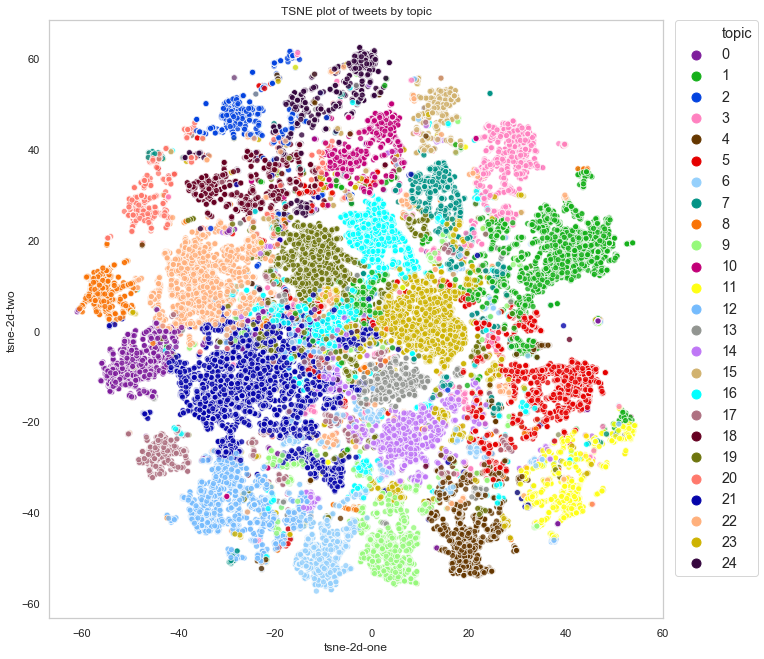

In [193]:
# pick 25 distinguishable colors from seaborn's xkcd (https://xkcd.com/color/rgb/)
color_str = '#7e1e9c, #15b01a, #0343df, #ff81c0, #653700, #e50000, #95d0fc, #029386, #f97306, #96f97b, #c20078, #ffff14, #75bbfd, #929591, #bf77f6, #d1b26f, #00ffff, #ae7181, #650021, #6e750e, #ff796c, #0504aa, #ffb07c, #ceb301, #35063e'
color_list = color_str.split(', ')
custom_palette = sns.set_palette(sns.color_palette(color_list))

# plot scatterplot
plt.figure(figsize=(11,11))
plt.title('TSNE plot of tweets by topic')
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=df_convo_user.topic,
    palette=sns.color_palette(custom_palette), # "Paired", n_colors=25)
    data=tsne_nmf_df,
    legend="full",
    alpha=0.80
)
#plt.legend(fontsize='large', title_fontsize='10', markerscale=1.5)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize='large', title_fontsize='10', markerscale=1.5)
plt.savefig('tsne_2d_topic_plot.png');

### CorEx Model

In [199]:
# vectorize the text data using count vectorizer
vectorizer_convo_user = CountVectorizer(stop_words=my_stop_words, max_df=0.80, min_df=0.001, binary=True)
doc_word_convo_user = vectorizer_convo_user.fit_transform(df_convo_user.text_clean)    

In [200]:
# create list of all the words from the vectorized data 
words = list(np.asarray(vectorizer_convo_user.get_feature_names()))

In [201]:
# create corex model (without anchors)
corex_topic_model = ct.Corex(n_hidden=10, words=words,
                       max_iter=200, verbose=False, seed=1)

corex_topic_model.fit(doc_word_convo_user, words=words, docs=df_convo_user.text_clean)

# print all topics from the corex model
topics = corex_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: icloud, sierra, high, itunes, tried, photo, password, mac, id, trying
1: battery, io, iphone, screen, life, drain, plus, freeze, draining, lock
2: email, support, card, sent, store, account, service, message, order, number
3: app, music, apps, open, play, control, download, wifi, song, playing
4: pro, macbook, air, ipad, en, el, mi, se, meu, est
5: button, work, home, working, bar, turn, make, volume, sound, alarm
6: phone, update, new, freezing, updated, software, crashing, brand, randomly, newest
7: month, ago, old, year, bought, week, case, warranty, got, money
8: time, day, hour, problem, soon, amp, half, possible, multiple, couple
9: loud, laughing, think, sure, today, happened, worked, people, use, guy


In [202]:
# create corex model with product-specific anchors
corex_topic_model = ct.Corex(n_hidden=4, words=words,
                       max_iter=200, verbose=False, seed=1)

corex_topic_model.fit(doc_word_convo_user, words=words, docs=df_convo_user.text_clean, 
                anchors=[['iphone', 'iphones', 'phone', 'io'], 
                         ['mac', 'macbook', 'macos', 'air'],
                         ['ipad'],                         
                         ['watch', 'watchos']], anchor_strength=5)

# print all topics from the corex model
topics = corex_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: iphone, io, plus, battery, update, new, phone, latest, updated, life
1: macbook, mac, air, macos, sierra, pro, high, drive, retina, file
2: ipad, app, screen, tried, music, apps, time, setting, wifi, work
3: watch, watchos, support, customer, day, store, ago, series, service, hour


In [203]:
# probability of y given x
corex_topic_model.p_y_given_x[0]

array([1.08783970e-05, 1.06967865e-05, 4.98420182e-04, 9.99999000e-01])

In [204]:
# percent of tweets labelled with a topic
sum(corex_topic_model.labels.any(axis=1)) / df_convo_user.shape[0]

0.5589641162211069

In [205]:
# top documents associated with topic : watch
corex_topic_model.get_top_docs(topic=3, n_docs=5)

[('applesupport uh weirdness watchos update http co', 0.0),
 ('applesupport got zero help told would need wait business hour get call back day get replacement applesupport also really appreciated told situation like people always telling truth seriously applesupport wanted order watch birthday applesupport thank quick follow manager applesupport address unfortunate issue look forward resolving asap applesupport sent dm tried place reorder told soonest could get item ordered day later get straight answer clearly frustrated laughed nice work applesupport',
  0.0),
 ('hulu support get error whenever try watch show apple tv cc applesupport http co',
  0.0),
 ('good news applesupport helped restore laptop former glory watch netflix bad news access',
  0.0),
 ('applesupport yes recently stopped day ago point apple watch notification even come applesupport',
  0.0)]

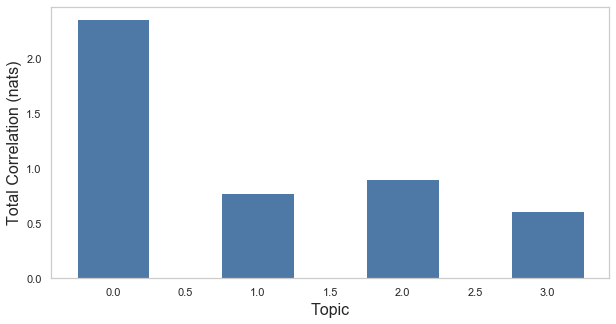

In [206]:
# plot total correlation for each topic
plt.figure(figsize=(10,5))
plt.bar(range(corex_topic_model.tcs.shape[0]), corex_topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

## Predict topic based on user's initial tweet

In [72]:
# copy dataframe as a new one
df_first_tweet_user = df.copy()

In [73]:
# tweets from users only
df_first_tweet_user = df_first_tweet_user[df_first_tweet_user.inbound == 'True']

In [74]:
# filter dataframe to first tweet per user only
df_first_tweet_user = df_first_tweet_user.loc[df_first_tweet_user.groupby('author_id').created_at.idxmin()].reset_index(drop=True)

In [75]:
# vectorize text data using tf-idf vectorizer
my_additional_stop_words = ['apple', 'applesupport', 'want', 'hey', 'hi', 'hello', 'http', 'thank', 'thanks', 'ok', 'yes', 'pls', 'plz', 'know', 'going', 'like', 'really', 'la', 'le', 'que', 'question', 'mark', 'help', 'need', 'issue']
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

tfidf_first_tweet_user = TfidfVectorizer(stop_words=my_stop_words, max_df=0.10, min_df=0.001, ngram_range=(1,3))
doc_word_first_tweet_user = tfidf_first_tweet_user.fit_transform(df_first_tweet_user.text_clean)

df_first_tweet_user_vec = pd.DataFrame(doc_word_first_tweet_user.toarray(), index=df_first_tweet_user.text_clean, columns=tfidf_first_tweet_user.get_feature_names())

In [76]:
df_first_tweet_user_vec.shape

(58578, 1259)

In [77]:
df_first_tweet_user_vec.sample(1)

,ability,able,able use,absolute,absolutely,access,accidentally,account,act,acting,...,wtf,wth,ya,yall,yeah,year,year old,yesterday,yo,youtube
text_clean,,,,,,,,,,,,,,,,,,,,,
applesupport phone stuck white update screen hour getting really hot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Topic Modeling

In [78]:
# use NMF to reduce dimensionality to some # of topics
nmf_model_first_tweet_user = NMF(25)
doc_topic_first_tweet_user = nmf_model_first_tweet_user.fit_transform(doc_word_first_tweet_user)

In [79]:
# topics by words
nmf_model_first_tweet_user.components_.shape

(25, 1259)

In [80]:
# distribution of words by topic
np.unique(doc_topic_first_tweet_user.argmax(axis=1), return_counts = True)[1]

array([4980, 4684, 1743, 2054, 3444, 2201, 1843, 2844, 1558, 1246, 1962,
       2243, 3244,  794, 1685, 1248,  968, 2579, 2791, 3521,  948, 3521,
       1431, 2177, 2869])

In [81]:
# topics by words into dataframe
topic_word_first_tweet_user = pd.DataFrame(nmf_model_first_tweet_user.components_.round(3),
                         #index = ["component_1", "component_2", "component_3", "component_4"]
                         columns = tfidf_first_tweet_user.get_feature_names())

topic_word_first_tweet_user.head()

,ability,able,able use,absolute,absolutely,access,accidentally,account,act,acting,...,wtf,wth,ya,yall,yeah,year,year old,yesterday,yo,youtube
0,0.000,0.180,0.013,0.000,0.000,0.187,0.058,0.032,0.000,0.000,...,0.007,0.000,0.011,0.002,0.021,0.000,0.000,0.023,0.004,0.109
1,0.000,0.000,0.000,0.010,0.041,0.000,0.000,0.000,0.002,0.000,...,0.023,0.006,0.000,0.001,0.000,0.047,0.022,0.016,0.007,0.013
2,0.000,0.023,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.014,0.003,0.000,0.008,0.000,0.021,0.004,0.000
3,0.007,0.077,0.010,0.000,0.000,0.000,0.000,0.000,0.003,0.011,...,0.003,0.011,0.013,0.007,0.005,0.000,0.000,0.000,0.101,0.000
4,0.001,0.021,0.000,0.008,0.013,0.000,0.000,0.000,0.010,0.039,...,0.031,0.002,0.009,0.007,0.000,0.035,0.017,0.002,0.024,0.000


In [213]:
display_topics(nmf_model_first_tweet_user, tfidf_first_tweet_user.get_feature_names(), 5)


Topic  0
app, store, app store, download, open

Topic  1
battery, life, battery life, drain, draining

Topic  2
problem, fix problem, problem iphone, fixed, solve

Topic  3
letter, type, type letter, eye, time type

Topic  4
new, new update, new io, new iphone, new phone

Topic  5
work, phone work, tried, work phone, iphone work

Topic  6
updated, updated phone, updated io, updated iphone, seeing

Topic  7
time, day, time day, time type, phone time

Topic  8
shit, fix shit, fuck, fucking, annoying

Topic  9
plus, iphone plus, plus io, iphone plus io, io iphone plus

Topic  10
screen, lock, lock screen, black, home

Topic  11
music, song, itunes, play, music app

Topic  12
got, email, account, id, got email

Topic  13
happening, thing, explain, started, idea

Topic  14
working, stopped, stopped working, stop, stop working

Topic  15
glitch, fix glitch, annoying, fixed, keyboard

Topic  16
box, seeing, seeing box, thing, fix box

Topic  17
turn, wifi, bluetooth, turning, automatically



In [ ]:
doc_topic_nmf_first_tweet_user = pd.DataFrame(doc_topic_first_tweet_user.round(5),
                             index = df_first_tweet_user.text_clean) 
doc_topic_nmf_first_tweet_user.head(3)

### CorEx Model

In [113]:
# train test split
X_train, X_test = train_test_split(df_first_tweet_user, test_size=0.2)

In [118]:
# vectorize text data using count vectorizer
vectorizer_first_tweet = CountVectorizer(stop_words=my_stop_words, max_df=0.50, min_df=0.001, binary=True)
doc_word_first_tweet = vectorizer_first_tweet.fit_transform(X_train.text_clean)
doc_word_first_tweet_test = vectorizer_first_tweet.transform(X_test.text_clean)

In [120]:
# create list of all the words from the vectorized data 
words = list(np.asarray(vectorizer_first_tweet.get_feature_names()))

In [132]:
# create corex model (without anchors)
corex_topic_model = ct.Corex(n_hidden=5, words=words,
                       max_iter=200, verbose=False, seed=1)

corex_topic_model.fit(doc_word_first_tweet, words=words, docs=X_train.text_clean)

# print all topics from the corex model
topics = corex_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: battery, update, io, life, phone, latest, new, drain, slow, draining
1: screen, pro, macbook, wifi, sierra, high, lock, home, button, bluetooth
2: app, music, store, itunes, account, id, song, card, download, password
3: iphone, letter, type, day, hour, box, charge, month, old, minute
4: email, photo, message, text, icloud, deleted, send, storage, received, picture


In [133]:
# create corex model with product-specific anchors
corex_topic_model = ct.Corex(n_hidden=4, words=words,
                       max_iter=200, verbose=False, seed=1)

corex_topic_model.fit(doc_word_first_tweet, words=words, docs=X_train.text_clean, 
                anchors=[['iphone', 'iphones', 'phone', 'io'], 
                         ['mac', 'macbook', 'macos', 'air'],
                         ['ipad'],                         
                         ['watch', 'watchos']], anchor_strength=5)

# print all topics from the corex model
topics = corex_topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ', '.join(topic_words))

0: iphone, phone, io, iphones, battery, update, new, updated, plus, freezing
1: macbook, mac, air, macos, pro, sierra, high, highsierra, file, drive
2: ipad, mini, smart, gen, tip, son, auto, disappearing, daily, ur
3: watch, app, screen, music, letter, fix, store, itunes, account, open


In [134]:
# probability of y given x
corex_topic_model.p_y_given_x

array([[2.50018729e-04, 1.29885316e-05, 1.00000000e-06, 8.48581448e-01],
       [8.46929499e-05, 1.29882214e-05, 1.00000000e-06, 4.17236651e-02],
       [9.99999000e-01, 1.40496636e-05, 1.00000000e-06, 3.29900719e-01],
       ...,
       [1.45912380e-04, 1.28407600e-05, 1.00000000e-06, 1.00000000e-06],
       [8.46929499e-05, 1.29882214e-05, 1.00000000e-06, 7.20180576e-02],
       [1.56104655e-03, 1.31924499e-05, 1.00000000e-06, 2.58879931e-02]])

In [135]:
# labels for each tweet
corex_topic_model.labels

array([[False, False, False,  True],
       [False, False, False, False],
       [ True, False, False, False],
       ...,
       [False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]])

In [136]:
# labels for each tweet
corex_topic_model.labels[7]

array([False, False, False, False])

In [137]:
# percent of tweets labelled with a topic
sum(corex_topic_model.labels.any(axis=1)) / X_train.shape[0]

0.6856514873458239

In [138]:
# top documents associated with topic : macbook
corex_topic_model.get_top_docs(topic=1, n_docs=5)

[('applesupport mac much slower since upgrading new o highsierra really wish bothered upgrading',
  0.0),
 ('applesupport problem volume icon ipad air io http co', 0.0),
 ('applesupport macbook aufgeklappt und seitdem geht nichts mehr http co',
  0.0),
 ('applesupport mac book pro touch brand new constantly crashing', 0.0),
 ('applesupport shutdown mac last night turn trying reinstall macos throw error saying install',
  0.0)]

In [139]:
# shape of x train
X_train.shape

(46862, 9)

In [140]:
# shape of labels
corex_topic_model.labels.shape

(46862, 4)

In [144]:
# create dataframe based on labels
df_corex_doc_topic_first_tweet = pd.DataFrame(data=corex_topic_model.labels,   
                                              index=np.array(range(1, corex_topic_model.labels.shape[0]+1)),
                                              columns=np.array(range(1, 5)))  

df_corex_doc_topic_first_tweet.columns = ['iPhone/iOS', 'Mac/macOS', 'iPad/iPadOS', 'Watch/watchOS']

In [145]:
# create number of topics columns
df_corex_doc_topic_first_tweet['number_of_topics'] = df_corex_doc_topic_first_tweet.sum(axis=1)

In [146]:
# normalized distribution of number of topics
df_corex_doc_topic_first_tweet.number_of_topics.value_counts(normalize=True)

1    0.460416
0    0.314349
2    0.216124
3    0.008386
4    0.000726
Name: number_of_topics, dtype: float64

In [154]:
df_corex_doc_topic_first_tweet

,iPhone/iOS,Mac/macOS,iPad/iPadOS,Watch/watchOS,number_of_topics
1,False,False,False,True,1
2,False,False,False,False,0
3,True,False,False,False,1
4,False,False,False,False,0
5,True,False,False,False,1
...,...,...,...,...,...
46858,True,False,False,False,1
46859,True,False,False,False,1
46860,False,False,False,False,0
46861,False,False,False,False,0


### Make predictions on test tweet data

In [152]:
# make predictions on new sample tweets
predictions = pd.DataFrame(corex_topic_model.predict(doc_word_first_tweet_test))
predictions.head(3)

,0,1,2,3
0,True,False,False,False
1,False,False,False,False
2,False,False,False,False


In [174]:
# shape of predictions
predictions.shape

(11716, 4)

In [179]:
# how to get the labels for the test set?
corex_topic_model.labels.shape

(46862, 4)

In [176]:
# probabilities of topics on test tweets
# corex_topic_model.p_y_given_x

In [156]:
# create new dataframe based on labels
df_corex_doc_topic_first_tweet_test = pd.DataFrame(data=corex_topic_model.labels,   
                                              index=np.array(range(1, corex_topic_model.labels.shape[0]+1)),
                                              columns=np.array(range(1, 5)))  

df_corex_doc_topic_first_tweet_test.columns = ['iPhone/iOS', 'Mac/macOS', 'iPad/iPadOS', 'Watch/watchOS']

In [159]:
# create number of topics column
df_corex_doc_topic_first_tweet_test['number_of_topics'] = df_corex_doc_topic_first_tweet_test.sum(axis=1)

In [160]:
df_corex_doc_topic_first_tweet_test.head()

,iPhone/iOS,Mac/macOS,iPad/iPadOS,Watch/watchOS,number_of_topics
1,False,False,False,True,1
2,False,False,False,False,0
3,True,False,False,False,1
4,False,False,False,False,0
5,True,False,False,False,1


In [161]:
df_corex_doc_topic_first_tweet_test.number_of_topics.value_counts(normalize=True)

1    0.460416
0    0.314349
2    0.216124
3    0.008386
4    0.000726
Name: number_of_topics, dtype: float64

In [163]:
# merge df_first_tweet_user with df_corex_doc_topic_first_tweet with 
df_corex_doc_topics_test = pd.merge(X_test, df_corex_doc_topic_first_tweet_test, left_index=True, right_index=True)

In [165]:
# add topic label as a new column in dataframe
def topic_label(num):
    if num == 1:
        return 'Exactly one of four topics'     
    else:
        return 'All other'

df_corex_doc_topics_test['topic_label'] = df_corex_doc_topics_test.number_of_topics.apply(topic_label)

In [169]:
df_corex_doc_topics_test[df_corex_doc_topics_test.number_of_topics == 1].sample(3)

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,date_only,text_clean,iPhone/iOS,Mac/macOS,iPad/iPadOS,Watch/watchOS,number_of_topics,topic_label
20779,2286750,384159,True,2017-11-12 00:27:36,@AppleSupport Hi. I unenrolled from iOS Beta P...,2286748,,2017-11-12,applesupport hi unenrolled io beta program del...,False,False,False,True,1,Exactly one of four topics
31000,1640692,501578,True,2017-11-05 21:20:26,@AppleSupport This I️ thing with the update is...,1640691,,2017-11-05,applesupport i️ thing update ridiculous help,False,False,False,True,1,Exactly one of four topics
45200,2123878,625615,True,2017-11-08 16:24:03,@AppleSupport How do I fix this? It’s now happ...,"2123880,2123876",,2017-11-08,applesupport fix happening mac book pro amp ma...,False,False,False,True,1,Exactly one of four topics


In [173]:
df_corex_doc_topics_test[df_corex_doc_topics_test.tweet_id == 2123878].text.values

array(['@AppleSupport How do I fix this? It’s now happening on my Mac Book Pro &amp; my Mac Pro. It makes them almost unusable. They constantly pop up. https://t.co/JPI9kTNgGd'],
      dtype=object)